# DK analysis manuscript
calls functions from DK_analysis_functions.jl to import processed_h5 and analyze neural and behavioral outputs from ANTSUN 

calls functions from the GenAnalysis package to anazlye gen_outputs

## Reload data from processed_h5

In [1]:
# modify this path to where you saved DK_analysis_functions.jl
path_dk_analysis = "/home/candy/Notebook_prj_5ht/DK_analysis_functions.jl"
include(path_dk_analysis);

data_uid = "2022-08-02-31"; # change this to the dataset you want to look at

WebIO._IJuliaInit()

1-element Vector{Int64}:
 75

In [ ]:
# run this cell if this is a SWF702 dataset (with neuron ID labels, only on-food time points were recorded)
velocity, speed, rev_bin, rev_start_end, head_curvature, head_curv_deriv, traces_array, traces_array_F_F20, traces_array_original = reload_data_neuropal(data_uid);
nsm_idx = [75] # which neuron is labelled as NSM

In [ ]:
# run this cell if this is a SWF415 dataset (without neuron ID labels, both off-food and on-food time points were recorded)
velocity, speed, rev_bin, rev_start_end, stage_x, stage_y, pumping, head_curvature, head_curv_deriv, traces_array, traces_array_F_F20, traces_array_original, time_encounter = reload_data(data_uid);
nsm_idx = [75] # which neuron is labelled as NSM

In [2]:
times = 1:size(traces_array,2)

if time_encounter
    continue
else
    time_encounter = 1
end
post_encounter_times = time_encounter:times[end];

In [3]:
# remove noise with GSTV and interpolate extreme values
smooth_traces_array, interpolated_traces_array = smooth_neural_data(traces_array_F_F20; k=100, λ=0.025, fluc_thresh_std=3)

nsm = mean(interpolated_traces_array[nsm_idx,:], dims=1)
nsm_smooth = mean(smooth_traces_array[nsm_idx,:], dims=1);

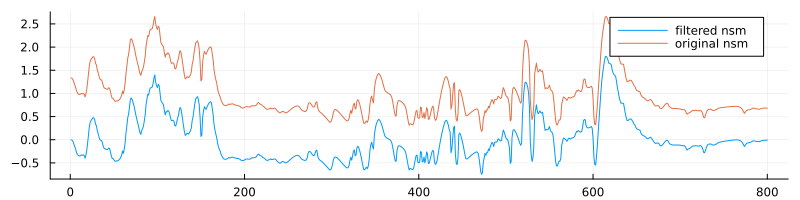

In [6]:
# filter away the very slow-changing trend that could be attributable to satiation or suboptimal bleach correction
# results arfe not substantially different if you skip this step
# just assign nsm_smooth to be filteredNSM

using PyCall
@pyimport scipy.signal as signal

b, a = signal.butter(1, 0.001, "highpass")
filteredNSM = signal.filtfilt(b, a, nsm)
Plots.plot(vec(filteredNSM), size=(800,200), label="filtered nsm")
plot!(vec(nsm), label="original nsm")

In [7]:
# filter away the very slow-changing trend that could be attributable to satiation or suboptimal bleach correction
# results arfe not substantially different if you skip this step
# just assign interpolated_traces_array to be filtered_traces_array

filtered_traces_array = zeros(size(interpolated_traces_array))

for n = 1:size(traces_array,1)
    neuron = interpolated_traces_array[n,:]
    filtered_traces_array[n,:] = signal.filtfilt(b, a, neuron)
end

## Visualize neural activity

In [8]:
path_garbageNSM = "/data1/prj_5ht/DK_analysis_output/NSM_like_garbage_library_neuroPAL_v2.jld2" # synthetic control traces for SWF702
path_garbageNSM = "/data1/prj_5ht/DK_analysis_output/NSM_like_garbage_library_slowPiezo.jld2" # synthetic control traces for SWF415 datasets recorded in Jan 2022
path_garbageNSM = "/data1/prj_5ht/DK_analysis_output/NSM_like_garbage_library_fastPiezo.jld2" # synthetic control traces for SWF415 datasets recorded in Mar-May 2022

f = jldopen(path_garbageNSM, "r")
NSM_like_garbage_dict = f["NSM_like_garbage_dict"]
close(f)

2909


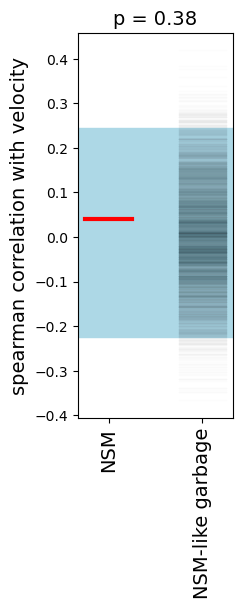

In [9]:
p_velocity, nsm_velocity_corr = swap_test_nsm(nsm, velocity, times, NSM_like_garbage_dict, "spearman correlation"; plot_=true, tail=2, y_label="with velocity");  

2909


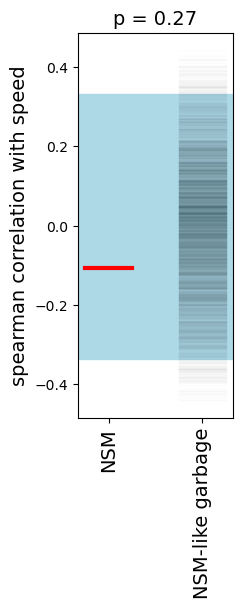

In [10]:
p_speed, nsm_speed_corr = swap_test_nsm(nsm, speed, post_encounter_times, NSM_like_garbage_dict, "spearman correlation"; plot_=true, tail=2, y_label="with speed");  

2909


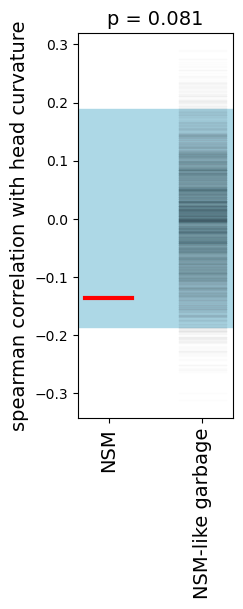

In [11]:
p_θh, nsm_θh_corr = swap_test_nsm(nsm, head_curvature, post_encounter_times, NSM_like_garbage_dict, "spearman correlation"; plot_=true, tail=2, y_label="with head curvature");

2909


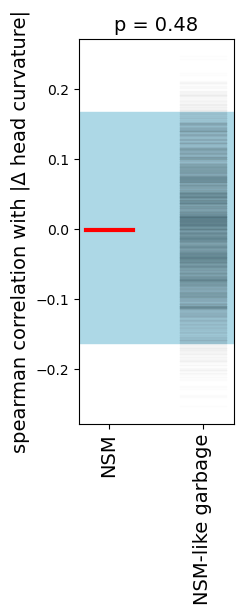

In [12]:
p_θh_diff, nsm_θh_diff_corr = swap_test_nsm(nsm, abs.(head_curv_deriv), post_encounter_times, NSM_like_garbage_dict, "spearman correlation"; plot_=true, tail=2, y_label="with |Δ head curvature|");  

## Test for significant association between kernel-convoluted NSM and PCs

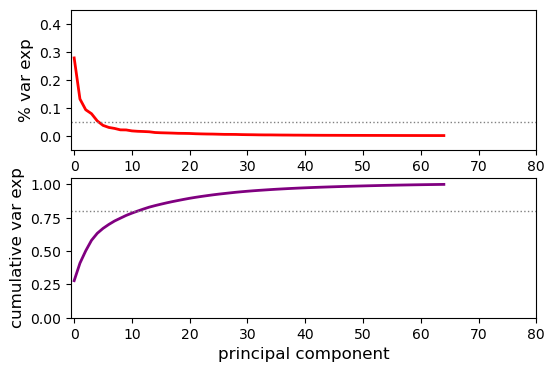

In [13]:
PC_post, var_exp_post, loading_post = neural_pca(filteredNSM, filtered_traces_array; times=times, plot_var_exp=true, plot_pcs=false);

In [14]:
winner_param_all_pcs, p_val_uncorr_pc, p_val_corr_pc, sig_pc_idx, gof_distribution_pc = swap_test_nsm_kernels_centered(filteredNSM, PC_post[1:sum(var_exp_post.>0.02), :], [], times, NSM_like_garbage_dict; fdr=0.1, tail=2, piezo_rate=1.65);

2916
12345678910

In [15]:
# see which PC is significantly associated with NSM after multiple test correction
sig_pc_idx

2-element Vector{Float64}:
 4.0
 7.0

In [16]:
winner_param_all_pcs_diff, p_val_uncorr_pc_diff, p_val_corr_pc_diff, sig_pc_idx_diff, gof_distribution_pc_diff = swap_test_nsm_kernels_differentiator(filteredNSM, PC_post[1:sum(var_exp_post.>0.02), :], [], times, NSM_like_garbage_dict; fdr=0.1, tail=2, piezo_rate=1.65);

2373
12345678910

In [17]:
# see which PC is significantly associated with NSM derivative after multiple test correction
sig_pc_idx_diff

Float64[]

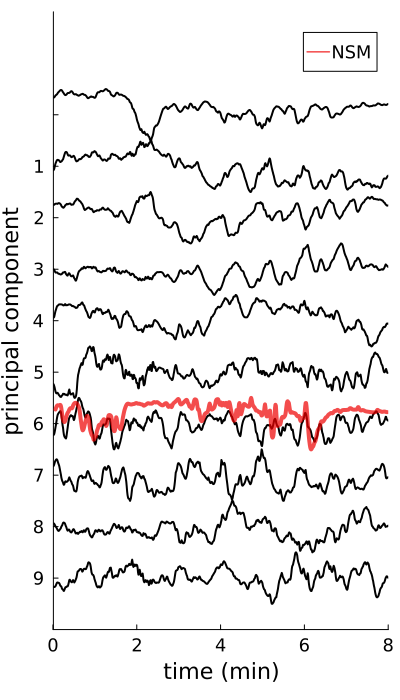

In [18]:
# visualize as did in fig 6E
k = 0.5
Plots.plot(size=(400,700))
for i = collect(sum(var_exp_post.>0.02) : -1:1)
    plot!(unitRange_trace(PC_post[i,:]) .+k, c="black", linewidth=2, label=nothing, yticks=(collect(1:sum(var_exp_post.>0.02)),["9", "8", "7", "6", "5", "4", "3", "2", "1"]), ylabel="principal component")
    if length(sig_pc_idx)>0
        if i == findall(x->x == minimum(p_val_corr_pc), p_val_corr_pc)[1]
            kernel, len1, len2 = make_kernel(0, winner_param_all_pcs[1,i][1], 16, winner_param_all_pcs[2,i][1], 0)
            nsm_convolved, start_t, stop_t = conv_nsm(filteredNSM, post_encounter_times, kernel, len1, len2)
            plot!(start_t:stop_t, unitRange_trace(-nsm_convolved) .+k, linewidth=4, legendfontsize=12, label="NSM", color=:red2, legend =:topright, alpha=0.7)
        end
    end
    
    if length(sig_pc_idx_diff)>0
        if i == findall(x->x == minimum(p_val_corr_pc_diff), p_val_corr_pc_diff)[1]
            kernel, len1, len2 = make_differentiator_kernel(-8, winner_param_all_pcs_diff[1,i][1], 8)
            nsm_convolved, start_t, stop_t = conv_nsm(filteredNSM, post_encounter_times, kernel, len1, len2)
            plot!(start_t:stop_t, unitRange_trace(nsm_convolved) .+k, linewidth=4, legendfontsize=12, label="NSM derivative", color=:olivedrab3, legend =:topright, alpha=0.7)
        end
    end
    k = k+1
end
plot!(nsm[times], linewidth=3, label=nothing, alpha=0, 
    xlims=(times[1], times[end]), xlabel="time (min)", ylims = ((0,sum(var_exp_post.>0.02)+2)),
    xticks=([0, 200, 400, 600, 800], ["0", "2", "4", "6", "8"]), guidefontsize=15, tickfontsize=12, grid=:off)

In [19]:
if length(sig_pc_idx)>0
    nsm_pc_loading = loading_post[:,findall(x->x == minimum(p_val_corr_pc), p_val_corr_pc)];
else
    nsm_pc_loading = [];
end;
    
if length(sig_pc_idx_diff)>0
    nsm_pc_deriv_loading = loading_post[:,findall(x->x == minimum(p_val_corr_pc_diff), p_val_corr_pc_diff)];
else
    nsm_pc_deriv_loading = []
end;

Any[]

## Test for significant association between kernel-convoluted NSM and individual neurons

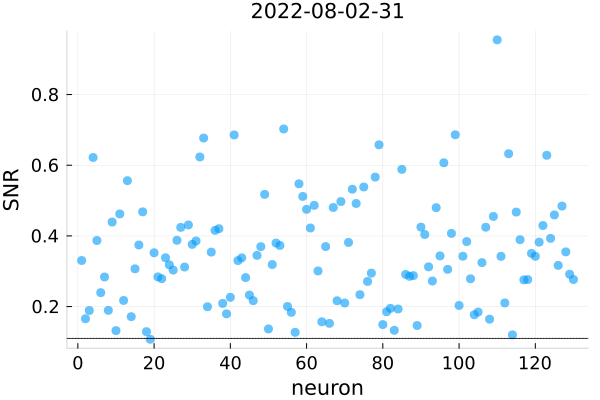

In [ ]:
noise_thresh = 0.11 # only examine a neuron's association with NSM if its signal surpasses random noise from motion artifacts
snr = measure_snr(traces_array_F_F20, times, noise_thresh)
noisy_idx = findall(x->x.<noise_thresh, snr);
Plots.scatter(1:size(traces_array_F_F20,1), snr, label=nothing, xlabel="neuron", ylabel="SNR", alpha=0.6,
    markersize=5, markerstrokewidth=0, tickfontsize=12, guidefontsize=14, foreground_color_border=:lightgrey)
hline!([noise_thresh], label=nothing, linestyle=:dot, color=:black, title=data_uid)

In [21]:
winner_param_all_neurons, p_val_uncorr, p_val_corr, sig_neuron_idx, gof_distribution = swap_test_nsm_kernels_centered(filteredNSM, filtered_traces_array, noisy_idx, post_encounter_times, NSM_like_garbage_dict; fdr=0.1, tail=2, piezo_rate=1.65);

2916
1234567891011121314151617182021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130

In [22]:
best_gof_all = zeros(length(p_val_uncorr))
for n = 1:length(p_val_uncorr)
    neuron = winner_param_all_neurons[end, n]
    best_gof_all[n] = gof_distribution[neuron][end]
end

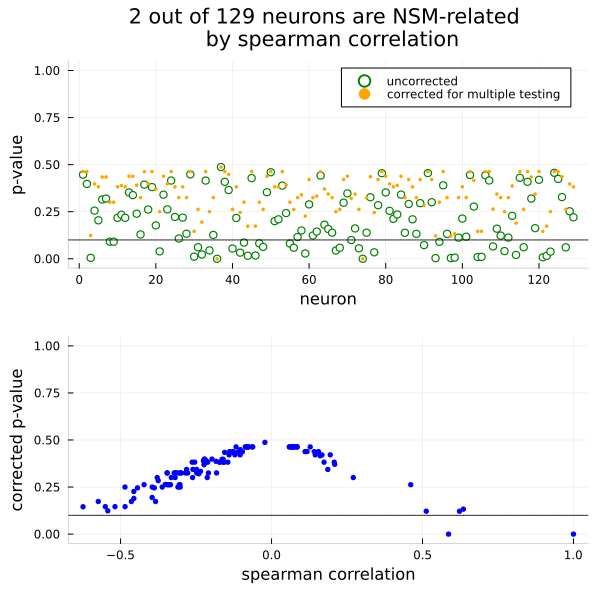

In [23]:
plot_sig_neurons(p_val_uncorr, p_val_corr, sig_neuron_idx, best_gof_all; method="spearman correlation", fdr=0.1)

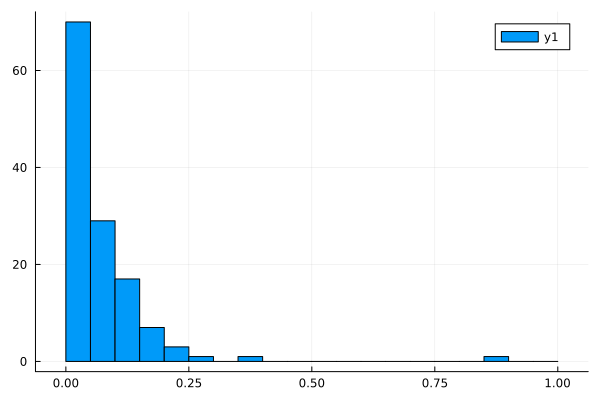

In [24]:
using Polynomials, MultivariateStats
var_exp_linreg_all_GCaMP = []

for i = 1:length(p_val_corr)
    kernel, len1, len2 = make_kernel(0, winner_param_all_neurons[1,i], 16, winner_param_all_neurons[2,i], 0) #
    X, start_t, stop_t = conv_nsm(filteredNSM, post_encounter_times, kernel, len1, len2)
    n = Int.(winner_param_all_neurons[end,i])
    
    y = interpolated_traces_array[n, start_t:stop_t]
    sol = llsq(X, y)
    A, b = sol[1:end-1,:], sol[end,:]
    y_hat =  X*A .+ b
    var_exp_linreg = 1 - sum((y.-y_hat).^2) / sum((y.-mean(y)).^2)

    push!(var_exp_linreg_all_GCaMP, var_exp_linreg)
end

Plots.histogram(var_exp_linreg_all_GCaMP, bins=0:0.05:1)

In [25]:
# see if the best-fitting kernel-convolved NSM explains more variance in the neuron's activity than by random chance
thresh = 0.16991236699258042
filter1 = findall(x->x .< 0.1, MultipleTesting.adjust(p_val_uncorr, BenjaminiHochberg()))
filter2 = findall(x->x .> thresh, var_exp_linreg_all_GCaMP) 
println(winner_param_all_neurons[end, intersect(filter1, filter2)])

[37.0, 75.0]


In [27]:
sig_neuron_idx_twice = winner_param_all_neurons[end, intersect(filter1, filter2)];

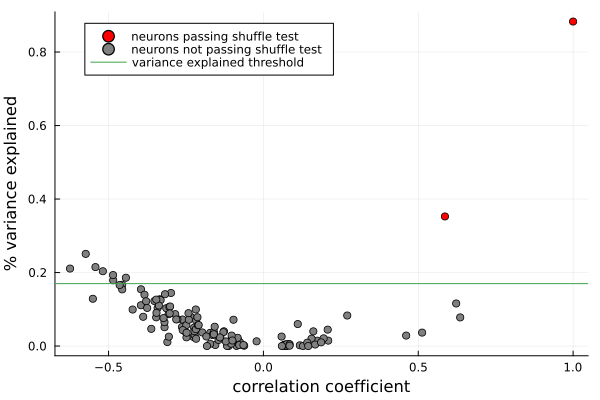

In [28]:
Plots.scatter(best_gof_all[findall(x->x in sig_neuron_idx, winner_param_all_neurons[end,:])], var_exp_linreg_all_GCaMP[findall(x->x in sig_neuron_idx, winner_param_all_neurons[end,:])], color = "red", label="neurons passing shuffle test")
scatter!(best_gof_all[findall(x->x ∉ sig_neuron_idx, winner_param_all_neurons[end,:])], var_exp_linreg_all_GCaMP[findall(x->x ∉ sig_neuron_idx, winner_param_all_neurons[end,:])], color = "grey", label="neurons not passing shuffle test")
hline!([thresh], label = "variance explained threshold", xlabel = "correlation coefficient", ylabel = "% variance explained", legend =:top)

In [29]:
# repeat the drill for NSM derivative
winner_param_all_neurons_diff, p_val_uncorr_diff, p_val_corr_diff, sig_neuron_idx_diff, gof_distribution_diff = swap_test_nsm_kernels_differentiator(filteredNSM, filtered_traces_array, noisy_idx, post_encounter_times, NSM_like_garbage_dict; fdr=0.05, tail=2, piezo_rate=1.65);

2373
1234567891011121314151617182021222324252627282930313233343536373839404142434445464748495051525354555657585960616263646566676869707172737475767778798081828384858687888990919293949596979899100101102103104105106107108109110111112113114115116117118119120121122123124125126127128129130

In [30]:
best_gof_all_diff = zeros(length(p_val_uncorr_diff))
for n = 1:length(p_val_uncorr_diff)
    neuron = Int.(winner_param_all_neurons_diff[end, n])
    best_gof_all_diff[n] = gof_distribution_diff[neuron][end]
end

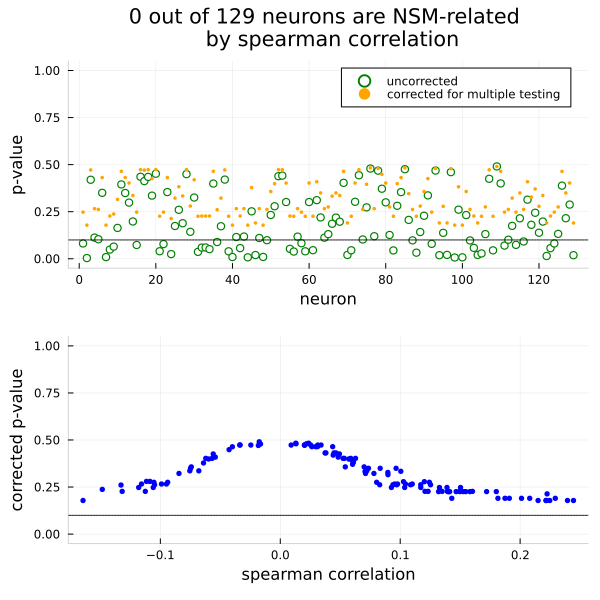

In [31]:
plot_sig_neurons(p_val_uncorr_diff, p_val_corr_diff, sig_neuron_idx_diff, best_gof_all_diff; method="spearman correlation", fdr=0.1)
#Plots.savefig("nsm_neurons_kernel_1.png")

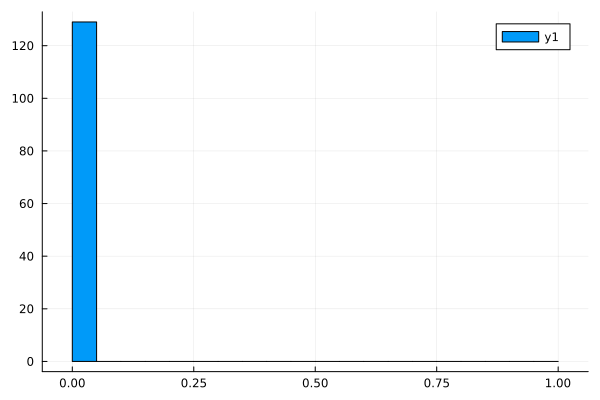

In [32]:
using Polynomials, MultivariateStats
var_exp_linreg_all_GCaMP_diff = []

for i = 1:length(p_val_corr_diff)
    kernel, len1, len2 = make_differentiator_kernel(-8, winner_param_all_neurons_diff[1,i], 8)
    X, start_t, stop_t = conv_nsm(filteredNSM, post_encounter_times, kernel, len1, len2)
    n = Int.(winner_param_all_neurons_diff[end,i])
    
    y = interpolated_traces_array[n, start_t:stop_t]
    sol = llsq(X, y)
    A, b = sol[1:end-1,:], sol[end,:]
    y_hat =  X*A .+ b
    var_exp_linreg = 1 - sum((y.-y_hat).^2) / sum((y.-mean(y)).^2)

    push!(var_exp_linreg_all_GCaMP_diff, var_exp_linreg)
end

Plots.histogram(var_exp_linreg_all_GCaMP_diff, bins=0:0.05:1)

In [33]:
thresh_diff = 0.055801848961637375
filter3 = findall(x->x .< 0.1, MultipleTesting.adjust(p_val_uncorr_diff, BenjaminiHochberg()))
filter4 = findall(x->x .> thresh_diff, var_exp_linreg_all_GCaMP_diff)
println(winner_param_all_neurons_diff[end, intersect(filter3, filter4)])

Float64[]


In [34]:
sig_neuron_idx_diff_twice = winner_param_all_neurons_diff[end, intersect(filter3, filter4)];

┌ Warning: Keyword argument letter not supported with Plots.GRBackend().  Choose from: annotations, arrow, aspect_ratio, background_color, background_color_inside, background_color_outside, background_color_subplot, bar_width, bins, bottom_margin, camera, clims, color_palette, colorbar, colorbar_entry, colorbar_scale, colorbar_title, connections, contour_labels, discrete_values, fill_z, fillalpha, fillcolor, fillrange, fillstyle, flip, foreground_color, foreground_color_axis, foreground_color_border, foreground_color_grid, foreground_color_subplot, foreground_color_text, framestyle, grid, gridalpha, gridlinewidth, gridstyle, group, guide, guidefontcolor, guidefontfamily, guidefonthalign, guidefontrotation, guidefontsize, guidefontvalign, html_output_format, inset_subplots, label, layout, left_margin, legend_background_color, legend_font_color, legend_font_family, legend_font_halign, legend_font_pointsize, legend_font_rotation, legend_font_valign, legend_foreground_color, legend_positio

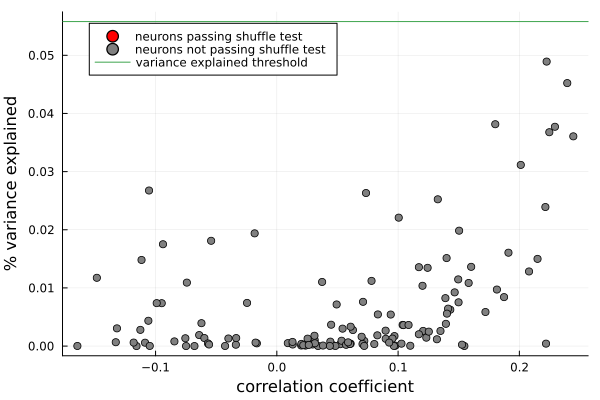

In [35]:
Plots.scatter(best_gof_all_diff[findall(x->x in sig_neuron_idx_diff, winner_param_all_neurons_diff[end,:])], var_exp_linreg_all_GCaMP_diff[findall(x->x in sig_neuron_idx_diff, winner_param_all_neurons_diff[end,:])], color = "red", label="neurons passing shuffle test")
scatter!(best_gof_all_diff[findall(x->x ∉ sig_neuron_idx_diff, winner_param_all_neurons_diff[end,:])], var_exp_linreg_all_GCaMP_diff[findall(x->x ∉ sig_neuron_idx_diff, winner_param_all_neurons_diff[end,:])], color = "grey", label="neurons not passing shuffle test")
hline!([thresh_diff], label = "variance explained threshold", xlabel = "correlation coefficient", ylabel = "% variance explained", legend =:top)

In [36]:
dict_path = "/data1/prj_5ht/DK_analysis_output/NeuroPAL_labels_dict.jld2"
if isfile(dict_path)
    f = JLD2.jldopen(dict_path)
    NeuroPAL_labels = f["NeuroPAL_labels"]
    close(f)
end
match_dict = NeuroPAL_labels["dict_match_dict"][data_uid];

In [37]:
neuron_identity = Dict()
neuron_identity_dv = Dict()
for i = 1:size(traces_array,1)
    if haskey(match_dict[1],i)
        neuron_identity[i] = match_dict[1][i]["neuron_class"]
        dv = match_dict[1][i]["DV"]
        if dv == "undefined"
            neuron_identity_dv[i] = neuron_identity[i]
        else
            neuron_identity_dv[i] = match_dict[1][i]["neuron_class"]*dv
        end
    else
        neuron_identity[i] = NaN
        neuron_identity_dv[i] = NaN
    end
end

In [38]:
sig_neuron_num = Int.(sig_neuron_idx)
sig_neuron_identity = []
sig_neuron_num_hasid = []

for i = keys(match_dict[1])
    if i in sig_neuron_num && haskey(match_dict[1],i)
        push!(sig_neuron_num_hasid, i)
        class = match_dict[1][i]["neuron_class"]
        dv = match_dict[1][i]["DV"]
        if dv == "undefined"
            push!(sig_neuron_identity, class)
        else
            push!(sig_neuron_identity, class*dv)
        end
    end
end

In [39]:
sig_neuron_kernel = Dict()
for i = 1:length(sig_neuron_num_hasid)
    n = sig_neuron_num_hasid[i]
    best_kernel = winner_param_all_neurons[1:end-1, findall(x->x==n, winner_param_all_neurons[end,:])]
    if haskey(sig_neuron_kernel, sig_neuron_identity[i])
        sig_neuron_kernel[sig_neuron_identity[i]] = hcat(sig_neuron_kernel[sig_neuron_identity[i]], best_kernel)
    else
        sig_neuron_kernel[sig_neuron_identity[i]] = best_kernel
    end
end

In [40]:
sig_neuron_num_diff = Int.(sig_neuron_idx_diff)
sig_neuron_identity_diff = []
sig_neuron_num_hasid_diff = []

for i = keys(match_dict[1])
    if i in sig_neuron_num_diff && haskey(match_dict[1],i)
        push!(sig_neuron_num_hasid_diff, i)
        class = match_dict[1][i]["neuron_class"]
        dv = match_dict[1][i]["DV"]
        if dv == "undefined"
            push!(sig_neuron_identity_diff, class)
        else
            push!(sig_neuron_identity_diff, class*dv)
        end
    end
end

sig_neuron_diff_kernel = Dict()
for i = 1:length(sig_neuron_num_hasid_diff)
    n = sig_neuron_num_hasid_diff[i]
    best_kernel = winner_param_all_neurons_diff[1:end-1, findall(x->x==n, winner_param_all_neurons_diff[end,:])]
    if haskey(sig_neuron_diff_kernel, sig_neuron_identity_diff[i])
        sig_neuron_diff_kernel[sig_neuron_identity_diff[i]] = hcat(sig_neuron_diff_kernel[sig_neuron_identity_diff[i]], best_kernel)
    else
        sig_neuron_diff_kernel[sig_neuron_identity_diff[i]] = best_kernel
    end
end

## Save results

In [41]:
path_nsm_analysis_dict = "/data1/prj_5ht/data_processed_neuropal/nsm_analysis_dict_swf702_final.jld2" # for SWF702 datasets
path_nsm_analysis_dict = "/data1/prj_5ht/data_processed_neuropal/nsm_analysis_dict_swf415_v3.jld2" # for SWF415 datasets

if isfile(path_nsm_analysis_dict)
    f = JLD2.jldopen(path_nsm_analysis_dict)
    nsm_analysis_dict = f["nsm_analysis_dict"]
    close(f)
else
    nsm_analysis_dict = Dict()
end;

if haskey(nsm_analysis_dict, data_uid)
    nsm_analysis_dict[data_uid] = nsm_analysis_dict[data_uid]
else
    nsm_analysis_dict[data_uid] = Dict()
end

nsm_analysis_dict[data_uid]["nsm_idx"] = nsm_idx
nsm_analysis_dict[data_uid]["nsm"] = nsm
nsm_analysis_dict[data_uid]["nsm_smooth"] = nsm_smooth

nsm_analysis_dict[data_uid]["smooth_traces_array"] = smooth_traces_array
nsm_analysis_dict[data_uid]["noisy_idx"] = noisy_idx;
nsm_analysis_dict[data_uid]["times"] = times

nsm_analysis_dict[data_uid]["sig_pc_num"] = Int.(sig_pc_idx)
nsm_analysis_dict[data_uid]["sig_pc_deriv_num"] = Int.(sig_pc_idx_diff)

nsm_analysis_dict[data_uid]["sig_neuron_num"] = Int.(sig_neuron_idx)
nsm_analysis_dict[data_uid]["sig_neuron_num_diff"] = Int.(sig_neuron_idx_diff)

nsm_analysis_dict[data_uid]["sig_neuron_num_twice"] = Int.(sig_neuron_idx_twice)
nsm_analysis_dict[data_uid]["sig_neuron_num_diff_twice"] = Int.(sig_neuron_idx_diff_twice)

nsm_analysis_dict[data_uid]["nsm_pc_loading"] = nsm_pc_loading
nsm_analysis_dict[data_uid]["nsm_pc_deriv_loading"] = nsm_pc_deriv_loading

nsm_analysis_dict[data_uid]["p_uncorr"] = Dict()
nsm_analysis_dict[data_uid]["p_corr"] = Dict()
nsm_analysis_dict[data_uid]["nsm_related_class"] = Dict()
nsm_analysis_dict[data_uid]["nsm_kernel_rise_speed"] = Dict()
nsm_analysis_dict[data_uid]["nsm_kernel_decay_speed"] = Dict()
nsm_analysis_dict[data_uid]["nsm_kernel_length"] = Dict()
nsm_analysis_dict[data_uid]["nsm_kernel_retrospectiveness"] = Dict()
nsm_analysis_dict[data_uid]["nsm_corr_coef"] = Dict()
nsm_analysis_dict[data_uid]["var_exp_linreg_all_GCaMP"] = Dict()

nsm_analysis_dict[data_uid]["p_uncorr_diff"] = Dict()
nsm_analysis_dict[data_uid]["p_corr_diff"] = Dict()
nsm_analysis_dict[data_uid]["nsm_related_class_diff"] = Dict()
nsm_analysis_dict[data_uid]["nsm_kernel_speed_diff"] = Dict()
nsm_analysis_dict[data_uid]["nsm_kernel_length_diff"] = Dict()
nsm_analysis_dict[data_uid]["nsm_corr_coef_diff"] = Dict()
nsm_analysis_dict[data_uid]["var_exp_linreg_all_GCaMP_diff"] = Dict()

for i = 1:size(smooth_traces_array,1) # neuron_num
    if i in noisy_idx
        nsm_analysis_dict[data_uid]["p_uncorr"][i] = maximum(p_val_uncorr)
        nsm_analysis_dict[data_uid]["p_corr"][i] = maximum(p_val_corr)
        nsm_analysis_dict[data_uid]["nsm_related_class"][i] = 0
        nsm_analysis_dict[data_uid]["nsm_corr_coef"][i] = 0
        nsm_analysis_dict[data_uid]["nsm_kernel_rise_speed"][i] = 0
        nsm_analysis_dict[data_uid]["nsm_kernel_decay_speed"][i] = 0 
        nsm_analysis_dict[data_uid]["nsm_kernel_length"][i] = 0
        nsm_analysis_dict[data_uid]["nsm_kernel_retrospectiveness"][i] = 0
        nsm_analysis_dict[data_uid]["var_exp_linreg_all_GCaMP"][i] = 0
        
        nsm_analysis_dict[data_uid]["p_uncorr_diff"][i] = maximum(p_val_uncorr_diff)
        nsm_analysis_dict[data_uid]["p_corr_diff"][i] = maximum(p_val_corr_diff)
        nsm_analysis_dict[data_uid]["nsm_related_class_diff"][i] = 0
        nsm_analysis_dict[data_uid]["nsm_corr_coef_diff"][i] = 0
        nsm_analysis_dict[data_uid]["nsm_kernel_speed_diff"][i] = 0
        nsm_analysis_dict[data_uid]["nsm_kernel_length_diff"][i] = 0      
        nsm_analysis_dict[data_uid]["var_exp_linreg_all_GCaMP_diff"][i] = 0
        
    else
        j = findall(x->x == i, Int.(winner_param_all_neurons[end,:]))[1] ### neuron idx, not neuron num
        nsm_analysis_dict[data_uid]["p_uncorr"][i] = p_val_uncorr[j]
        nsm_analysis_dict[data_uid]["p_corr"][i] = p_val_corr[j]
        nsm_analysis_dict[data_uid]["nsm_corr_coef"][i] = best_gof_all[j]
        nsm_analysis_dict[data_uid]["var_exp_linreg_all_GCaMP"][i] = var_exp_linreg_all_GCaMP[j]
        
        nsm_analysis_dict[data_uid]["p_uncorr_diff"][i] = p_val_uncorr_diff[j]
        nsm_analysis_dict[data_uid]["p_corr_diff"][i] = p_val_corr_diff[j]        
        nsm_analysis_dict[data_uid]["nsm_corr_coef_diff"][i] = best_gof_all_diff[j]
        nsm_analysis_dict[data_uid]["var_exp_linreg_all_GCaMP_diff"][i] = var_exp_linreg_all_GCaMP_diff[j]
        
        ############################## normal kernels
        if i in nsm_analysis_dict[data_uid]["sig_neuron_num_twice"]
            nsm_analysis_dict[data_uid]["nsm_kernel_rise_speed"][i] = winner_param_all_neurons[1,j] / 1.65
            nsm_analysis_dict[data_uid]["nsm_kernel_decay_speed"][i] = winner_param_all_neurons[2,j] /1.65
            nsm_analysis_dict[data_uid]["nsm_kernel_length"][i] = (16/winner_param_all_neurons[1,j] + 16/winner_param_all_neurons[2,j] -1) / 1.65
            nsm_analysis_dict[data_uid]["nsm_kernel_retrospectiveness"][i] = (16/winner_param_all_neurons[1,j]) / (16/winner_param_all_neurons[2,j])
            
            if best_gof_all[j]>0 
                nsm_analysis_dict[data_uid]["nsm_related_class"][i] = 1 
            elseif best_gof_all[j]<0 
                nsm_analysis_dict[data_uid]["nsm_related_class"][i] = 2
            end
        else
            nsm_analysis_dict[data_uid]["nsm_related_class"][i] = 0
            nsm_analysis_dict[data_uid]["nsm_kernel_rise_speed"][i] = 0
            nsm_analysis_dict[data_uid]["nsm_kernel_decay_speed"][i] = 0
            nsm_analysis_dict[data_uid]["nsm_kernel_length"][i] = 0       
            nsm_analysis_dict[data_uid]["nsm_kernel_retrospectiveness"][i] = 0
        end
        
        ############################## differentiator kernels
        if i in nsm_analysis_dict[data_uid]["sig_neuron_num_diff_twice"]
            nsm_analysis_dict[data_uid]["nsm_kernel_speed_diff"][i] = winner_param_all_neurons[1,j] / 1.65
            nsm_analysis_dict[data_uid]["nsm_kernel_length_diff"][i] = (16/winner_param_all_neurons[1,j]) / 1.65   
            
            if best_gof_all_diff[j]>0
                nsm_analysis_dict[data_uid]["nsm_related_class_diff"][i] = 1
            elseif best_gof_all_diff[j]<0
                nsm_analysis_dict[data_uid]["nsm_related_class_diff"][i] = 2
            end
        else          
            nsm_analysis_dict[data_uid]["nsm_related_class_diff"][i] = 0
            nsm_analysis_dict[data_uid]["nsm_kernel_speed_diff"][i] = 0
            nsm_analysis_dict[data_uid]["nsm_kernel_length_diff"][i] = 0
        end
    end
end

nsm_analysis_dict[data_uid]["nsm_velocity_corr"] = nsm_velocity_corr
nsm_analysis_dict[data_uid]["nsm_speed_corr"] = nsm_speed_corr

nsm_analysis_dict[data_uid]["nsm_θh_corr"] = nsm_θh_corr
nsm_analysis_dict[data_uid]["nsm_θh_diff_corr"] = nsm_θh_diff_corr

nsm_analysis_dict[data_uid]["nsm_velocity_p"] = p_velocity
nsm_analysis_dict[data_uid]["nsm_speed_p"] = p_speed
nsm_analysis_dict[data_uid]["nsm_θh_p"] = p_θh
nsm_analysis_dict[data_uid]["nsm_θh_diff_p"] = p_θh_diff

nsm_analysis_dict[data_uid]["post_encounter_speed_mean"] = mean(speed[post_encounter_times])
nsm_analysis_dict[data_uid]["post_encounter_speed_std"] = std(speed[post_encounter_times])


if data_uid[7]=="7" || data_uid[7]=="8" #### neuropal datasets were recorded in July and August 2022
    nsm_analysis_dict[data_uid]["neuron_identity"] = neuron_identity
    nsm_analysis_dict[data_uid]["neuron_identity_dv"] = neuron_identity_dv
    nsm_analysis_dict[data_uid]["sig_neuron_num_hasid"] = sig_neuron_num_hasid
    nsm_analysis_dict[data_uid]["sig_neuron_kernel"] = sig_neuron_kernel
    nsm_analysis_dict[data_uid]["sig_neuron_identity"] = sig_neuron_identity

    nsm_analysis_dict[data_uid]["sig_neuron_num_hasid_diff"] = sig_neuron_num_hasid_diff
    nsm_analysis_dict[data_uid]["sig_neuron_diff_kernel"] = sig_neuron_diff_kernel
    nsm_analysis_dict[data_uid]["sig_neuron_identity_diff"] = sig_neuron_identity_diff
end

JLD2.@save(path_nsm_analysis_dict, nsm_analysis_dict)